In [1]:
import algo_hedging_combined_2 as algo
import datamodel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
class Data:
    def __init__(self, df):
        self.output = df
        self.times = df['timestamp'].unique()
        self.products = df['product'].unique()
        self.mtm_value = pd.DataFrame(index = df['timestamp'].unique())
        self.mtm_value.index.name = 'Time'
        self.mtm_value['Cash'] = 0
        self.mtm_value['Value'] = 0
        for product in self.products:
            self.mtm_value[product]=0
            self.mtm_value["Cash_"+product]=0
            self.mtm_value["Value_"+product]=0
def read_data():
    days = list(range(-1, 2))
    outputs = {}
    for day in days:
        fname = f"Data/prices_round_2_day_{day}.csv"
        df = pd.read_csv(fname, index_col=False, sep=";")
        outputs[day] = Data(df)
    return outputs

In [3]:
def process_data(outputs, short_period, long_period):
    for output in outputs.values():
        position = {}
        trader = algo.Trader(
        # asset_dicts = {"PEARLS":algo.Asset(20, 10, 10),
        # "BANANAS":algo.Asset(20, long_period, short_period)},
        # printing = False
        )
        for time in output.times:
            print(time)
            listings = {}
            order_depths = {}
            own_trades = {}
            market_trades = {}
            observations = {}
            for product in output.products:
                # print(data)
                depth = datamodel.OrderDepth()
                data = output.output[:][(output.output['timestamp']  ==time)& (output.output['product']==product)]
                try:
                    depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"]), int(data["bid_price_2"]):int(data["bid_volume_2"]), int(data["bid_price_3"]):int(data["bid_volume_3"])}
                except:
                    try:
                        depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"]), int(data["bid_price_2"]):int(data["bid_volume_2"])}
                    except:
                        depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"])}
                try:
                    depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"]), int(data["ask_price_2"]):-int(data["ask_volume_2"]), int(data["ask_price_3"]):-int(data["ask_volume_3"])}
                except:
                    try:
                        depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"]), int(data["ask_price_2"]):-int(data["ask_volume_2"])}
                    except:
                        depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"])}
                order_depths[product] = depth
            state = datamodel.TradingState(
                        timestamp= time,
                        listings= listings,
                        order_depths= order_depths,
                        own_trades= own_trades,
                        market_trades= market_trades,
                        position= position,
                        observations= observations)
            trades = trader.run(state = state)
            # breakdown by product
            cash_bd = {}
            value_bd = {}
            for product in output.products:
                cash_bd[product]= output.mtm_value.loc[time]['Cash_'+product]
            for trade in trades:
                if trade not in position:
                    try:
                        position[trade] =  trades[trade][0].quantity
                        cash_bd[trade] += -trades[trade][0].quantity*trades[trade][0].price
                    except:
                        continue
                else:
                    try:
                        position[trade] += trades[trade][0].quantity
                        cash_bd[trade] += -trades[trade][0].quantity*trades[trade][0].price
                    except:
                        continue
            # breakdown by product
            for product in output.products:
                value_bd[product]= cash_bd[product]
            # mtm valuation using best price to have no net assets
            for asset, pos in position.items():
                output.mtm_value.loc[time][asset] = pos
                if pos<0:
                    value_bd[asset] += pos*min(order_depths[asset].sell_orders.keys())
                if pos>0:
                    value_bd[asset] += pos*max(order_depths[asset].sell_orders.keys())


            output.mtm_value.loc[time]['Value'] = sum(value_bd.values())
            output.mtm_value.loc[time]['Cash'] = sum(cash_bd.values())
            for product in output.products:
                output.mtm_value.loc[time]['Cash_'+product] = cash_bd[product]
                output.mtm_value.loc[time]['Value_'+product] = value_bd[product]
            try:
                output.mtm_value.loc[time+100]['Cash'] = output.mtm_value.loc[time]['Cash']
                output.mtm_value.loc[time+100]['Value'] = output.mtm_value.loc[time]['Cash']
                for product in output.products:
                    output.mtm_value.loc[time+100]['Cash_'+product] = cash_bd[product]
                    output.mtm_value.loc[time+100]['Value_'+product] = cash_bd[product]
            except:
                continue

In [4]:
for long_period in range (200, 201):
    for short_period in range (150, 151):
        outputs = read_data()
        process_data(outputs, short_period, long_period)
        #  print(short_period, ' ', long_period)
        overall_pnl = 0
        for day, output in outputs.items():
            overall_pnl += int(output.mtm_value.tail(1)["Value"])
            print(day,int(output.mtm_value.tail(1)["Value"]))
        print(overall_pnl)

0


NameError: name 'stop' is not defined

In [ ]:
overall_pnl = 0
for day, output in outputs.items():
    overall_pnl += int(output.mtm_value.tail(1)["Value"])
    print(day,int(output.mtm_value.tail(1)["Value"]))
print(overall_pnl)

-1 -45989
0 -143338
1 68117
-121210


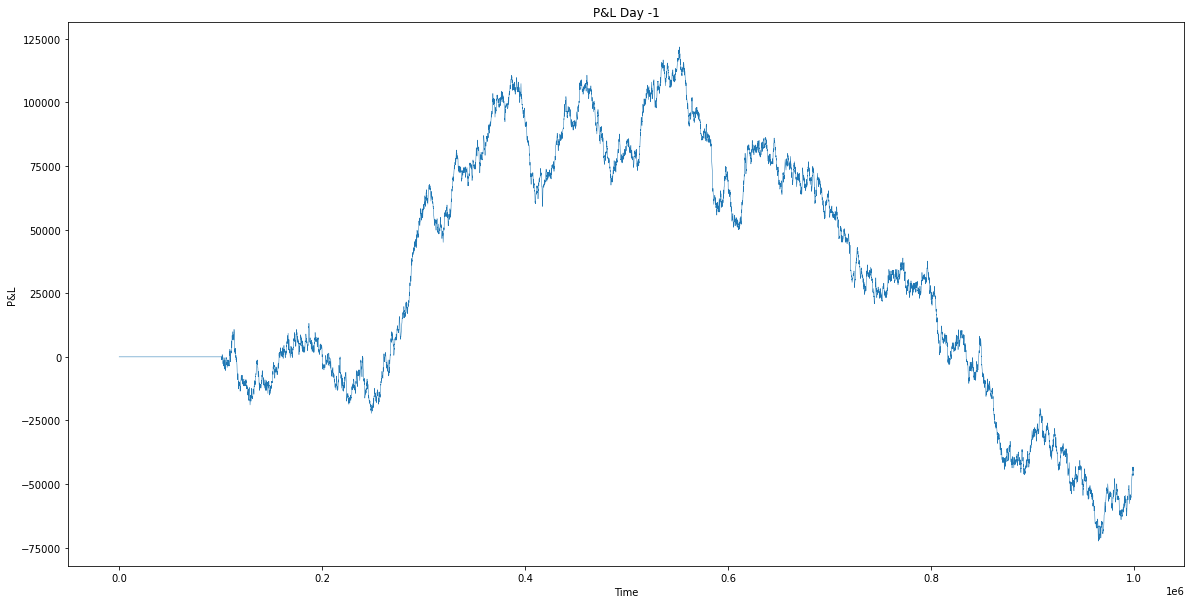

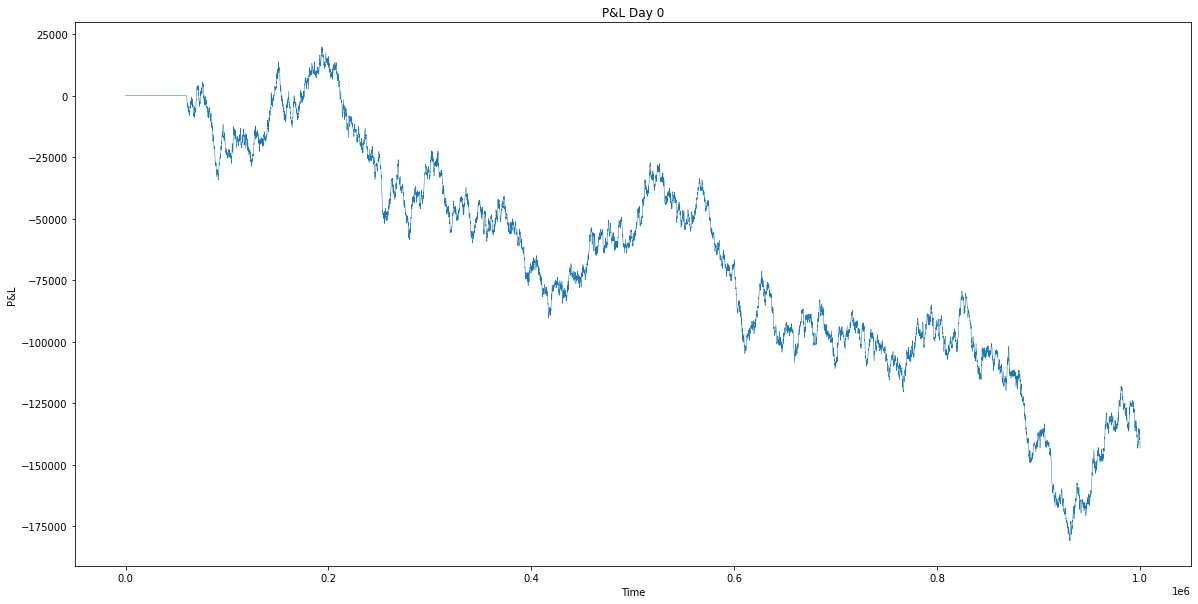

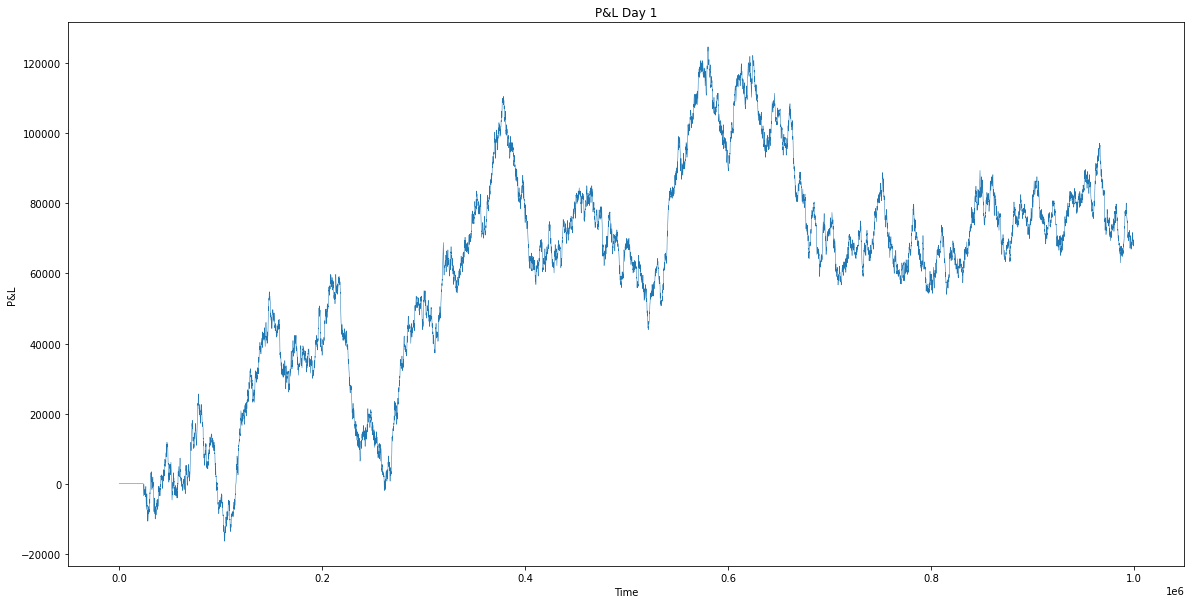

In [ ]:
for day, data in outputs.items():
    plt.plot(data.mtm_value['Value'] , linewidth = 0.5)
    plt.xlabel('Time')
    plt.ylabel('P&L')
    plt.title('P&L Day ' + str(day))
    plt.show()

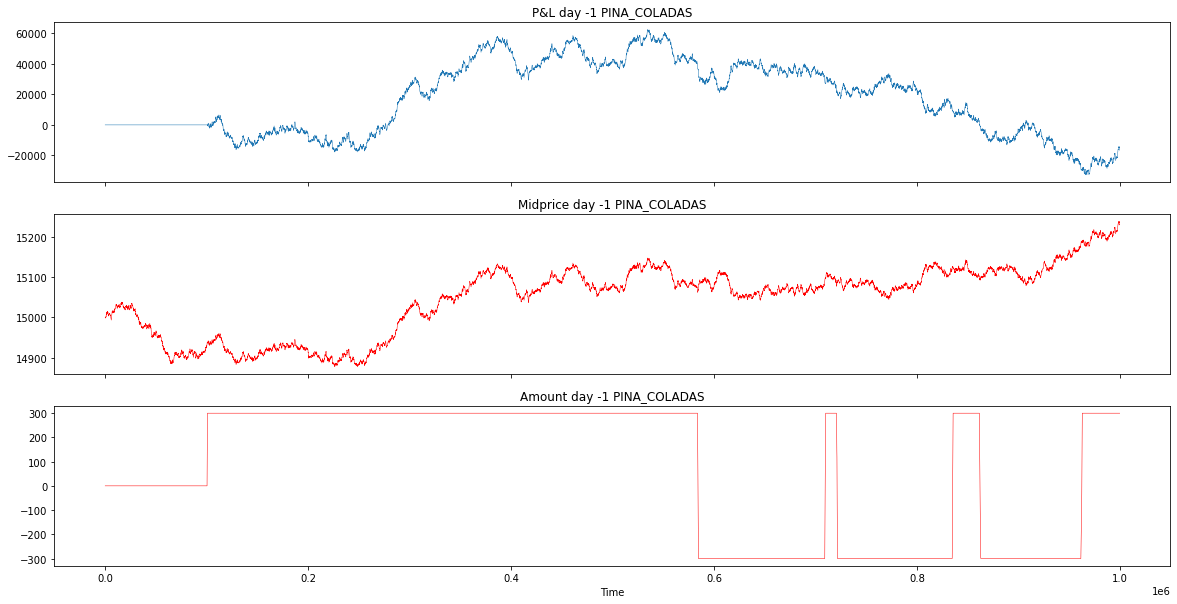

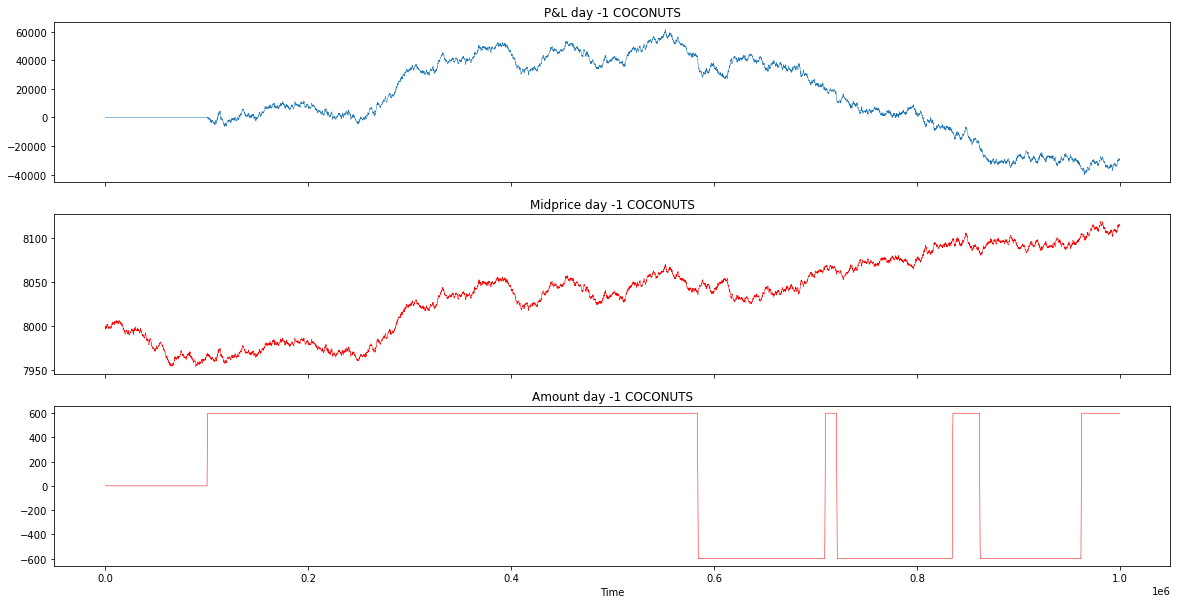

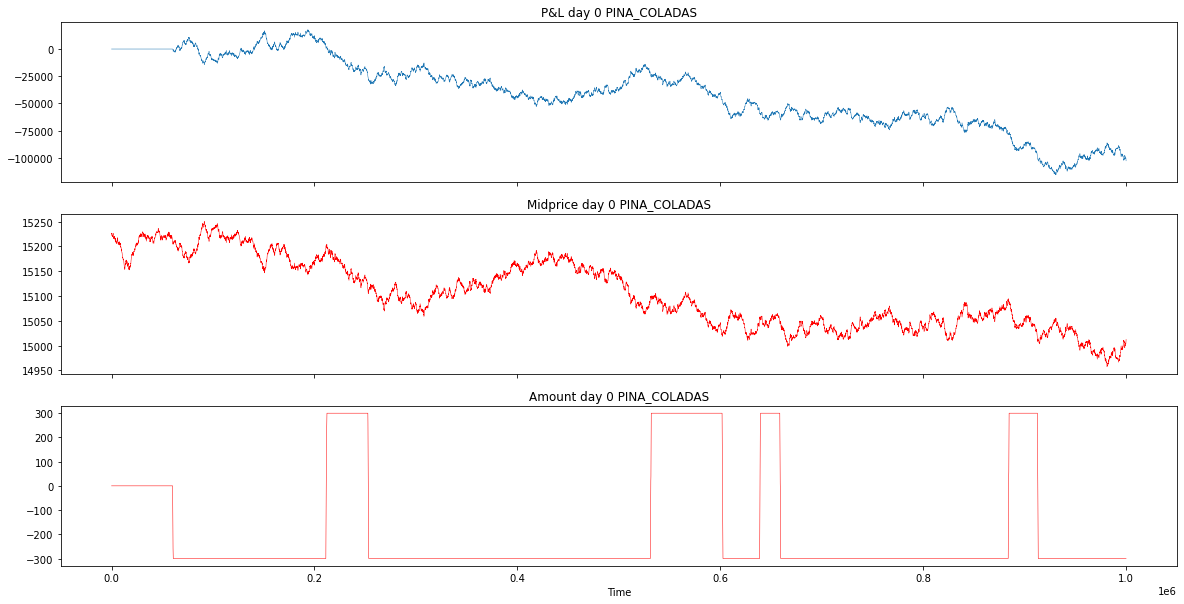

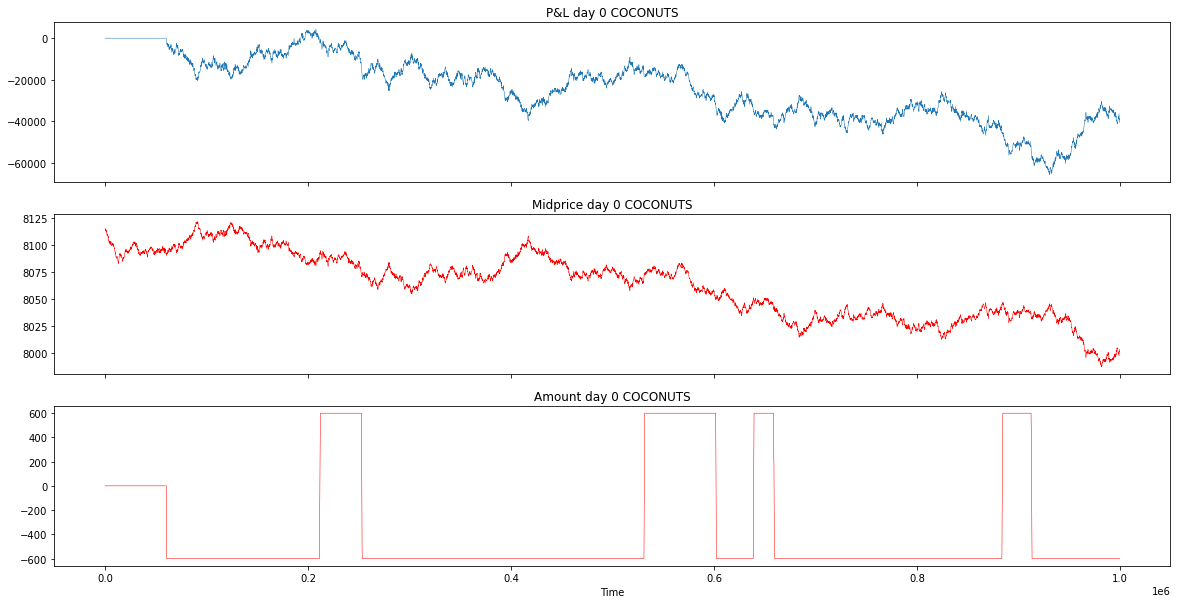

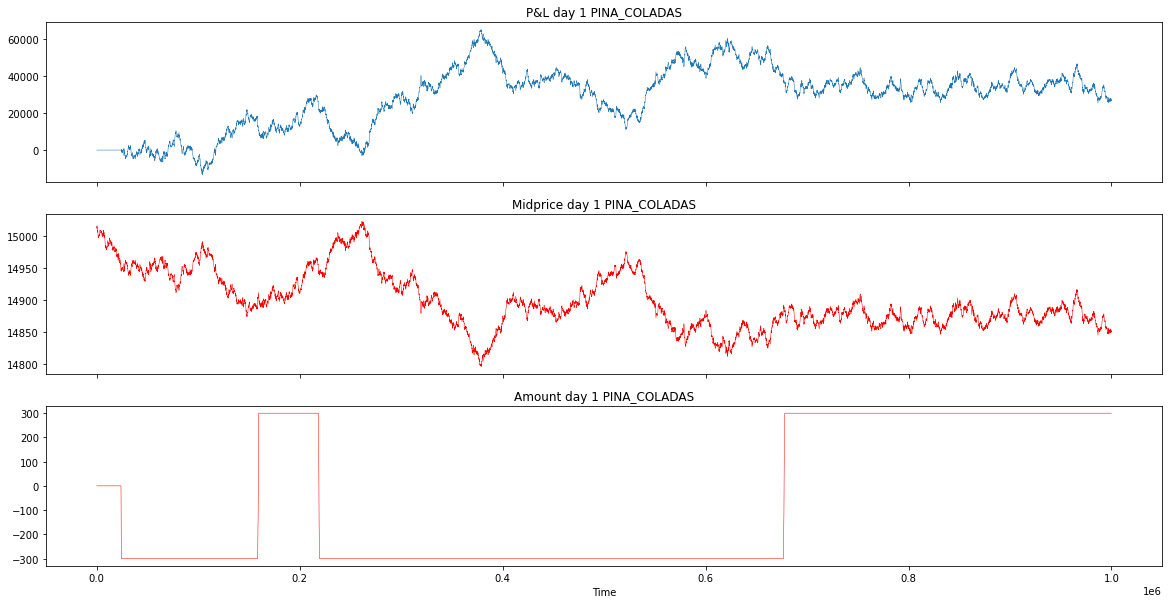

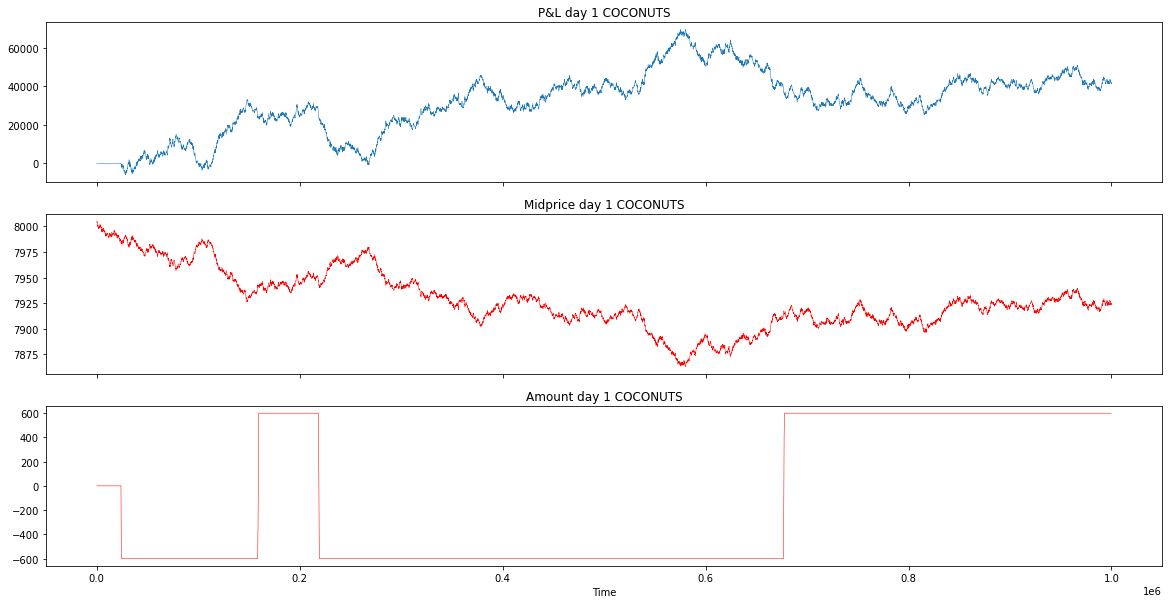

In [ ]:
for day, data in outputs.items():
    for product in data.products:
        if product in ['PINA_COLADAS', 'COCONUTS']:
            fig, axs = plt.subplots(3, sharex=True)
            axs[0].plot(data.mtm_value['Value_'+product] , linewidth = 0.5)
            axs[0].title.set_text(str('P&L day '+ str(day)+ ' '+ product))
            midprices = data.output[:][(data.output['product']==product)]
            axs[1].plot(midprices["timestamp"], midprices["mid_price"] , linewidth = 0.5, color = 'red')
            axs[1].title.set_text(str('Midprice day '+ str(day)+ ' '+ product))
            axs[2].plot(midprices["timestamp"], data.mtm_value[product] , linewidth = 0.5, color = 'red')
            axs[2].title.set_text(str('Amount day '+ str(day)+ ' '+ product))
            axs[2].set_xlabel('Time')
            plt.show()

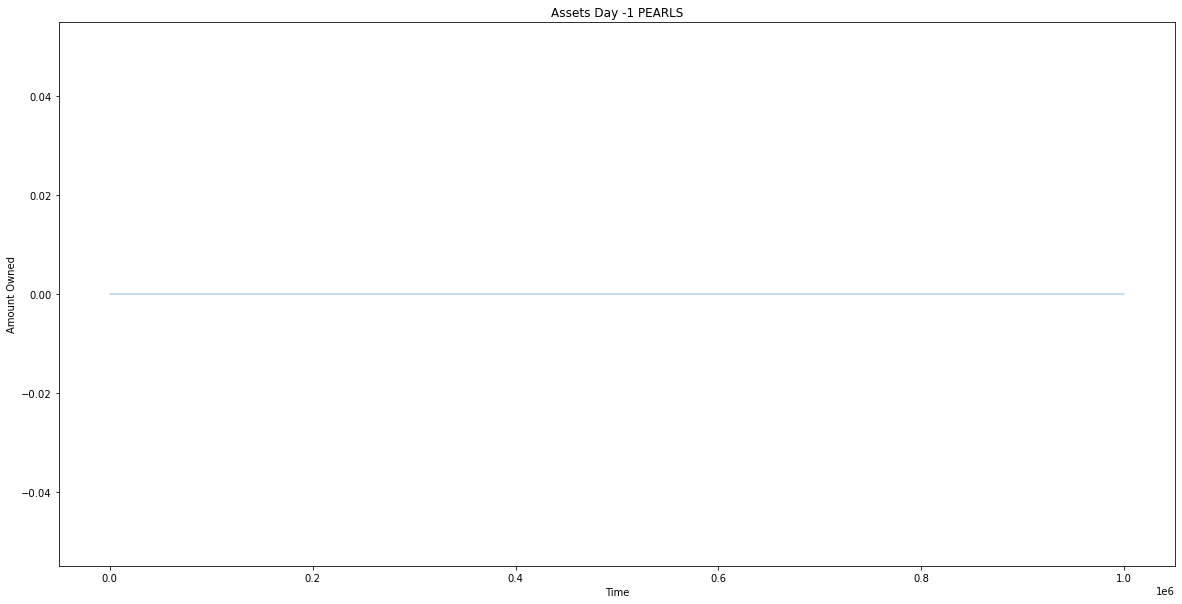

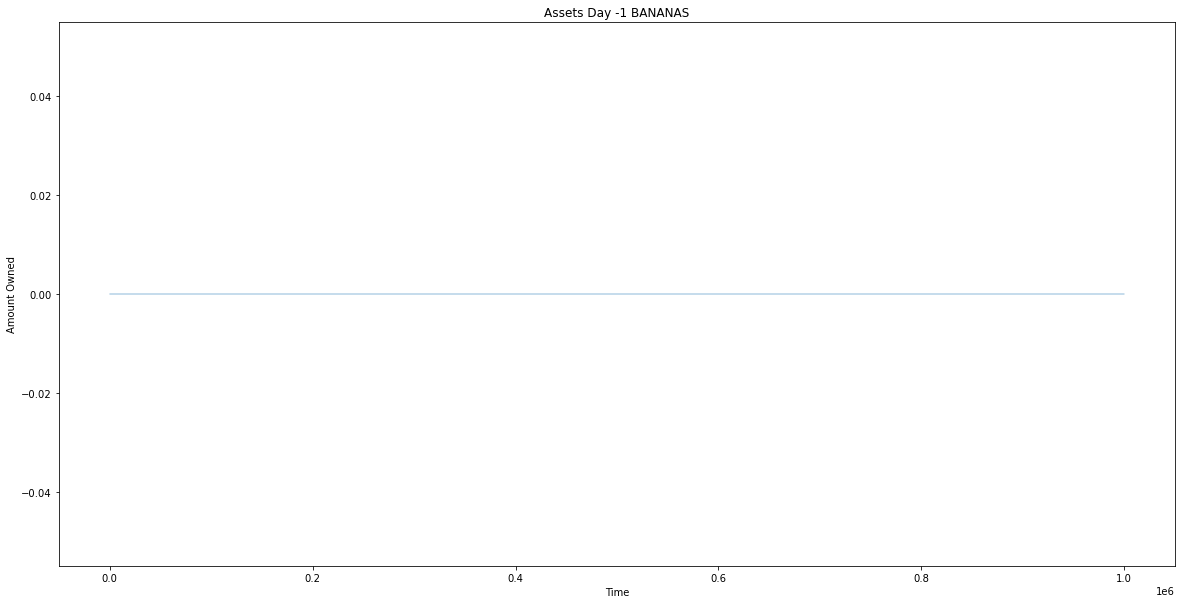

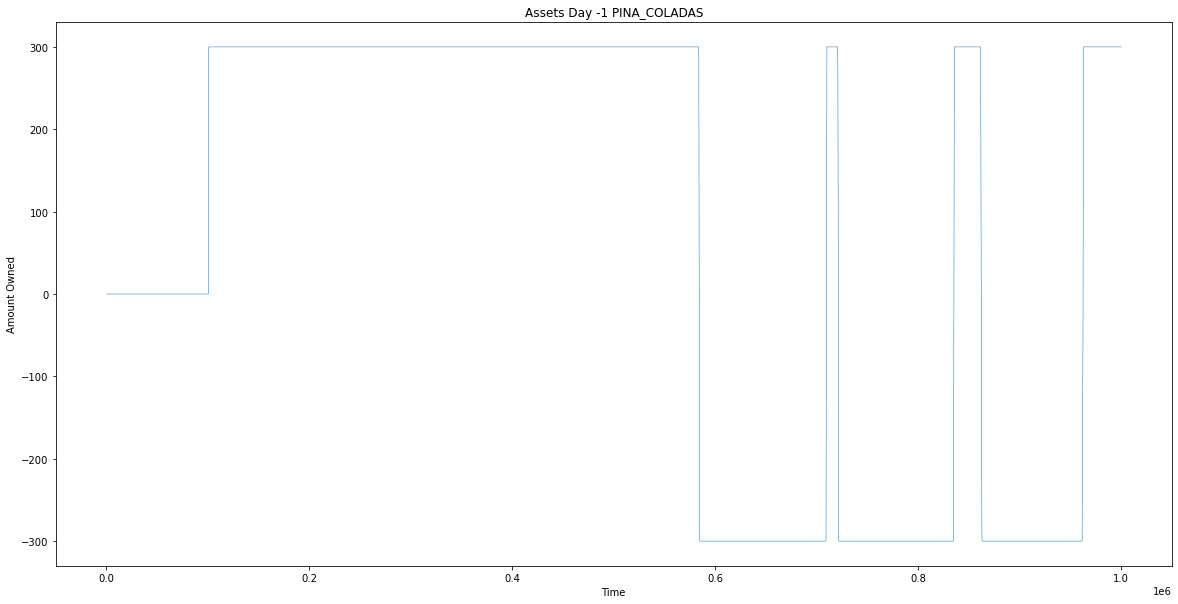

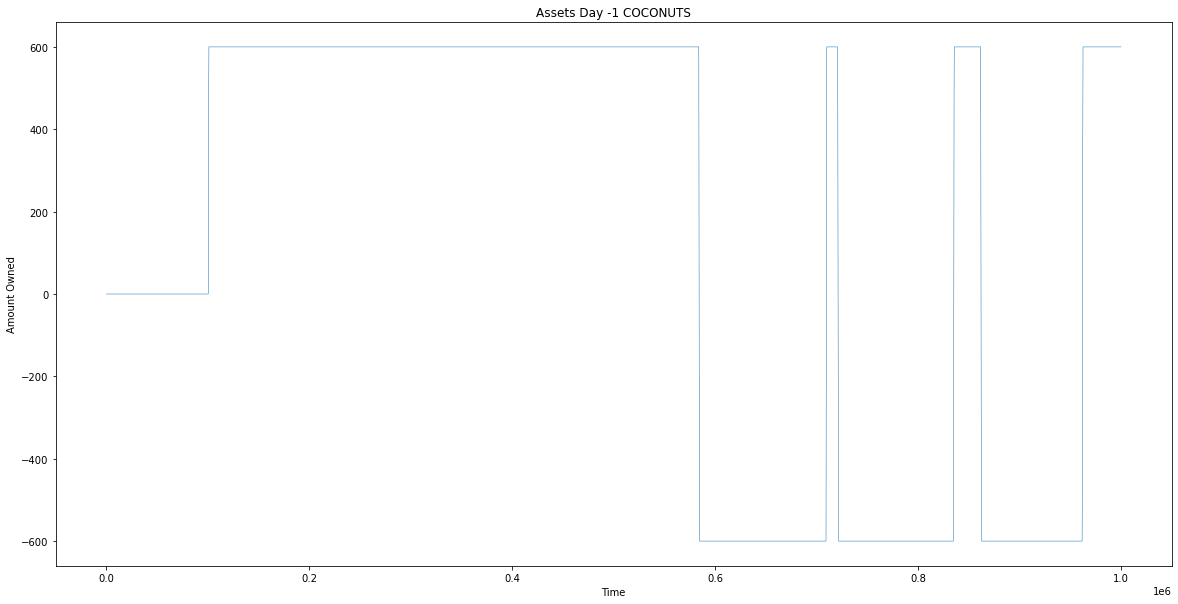

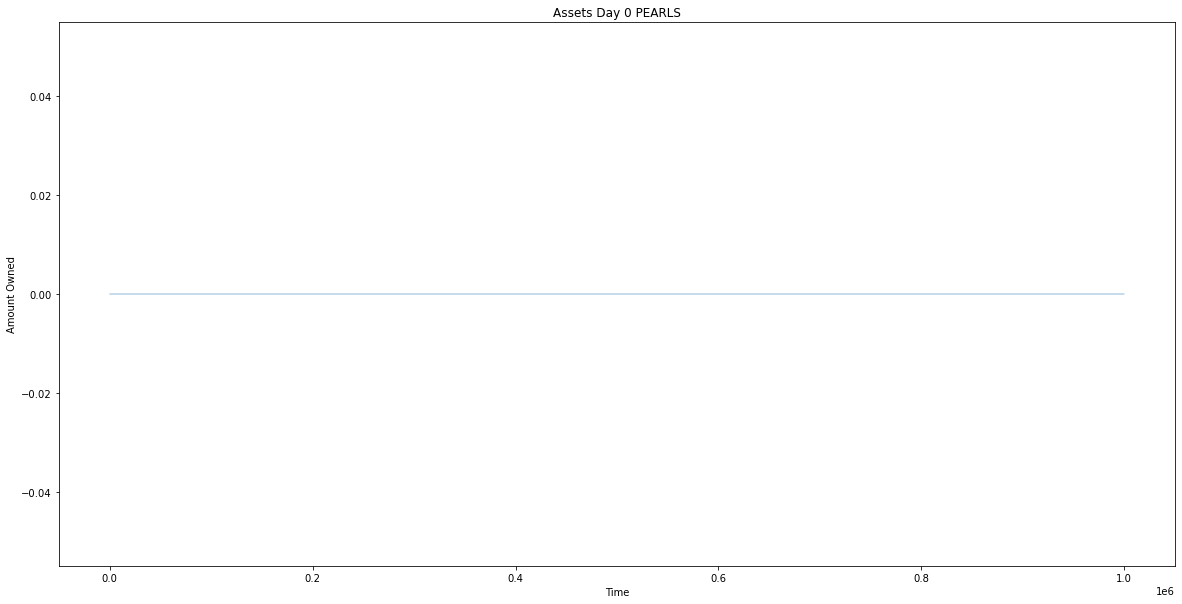

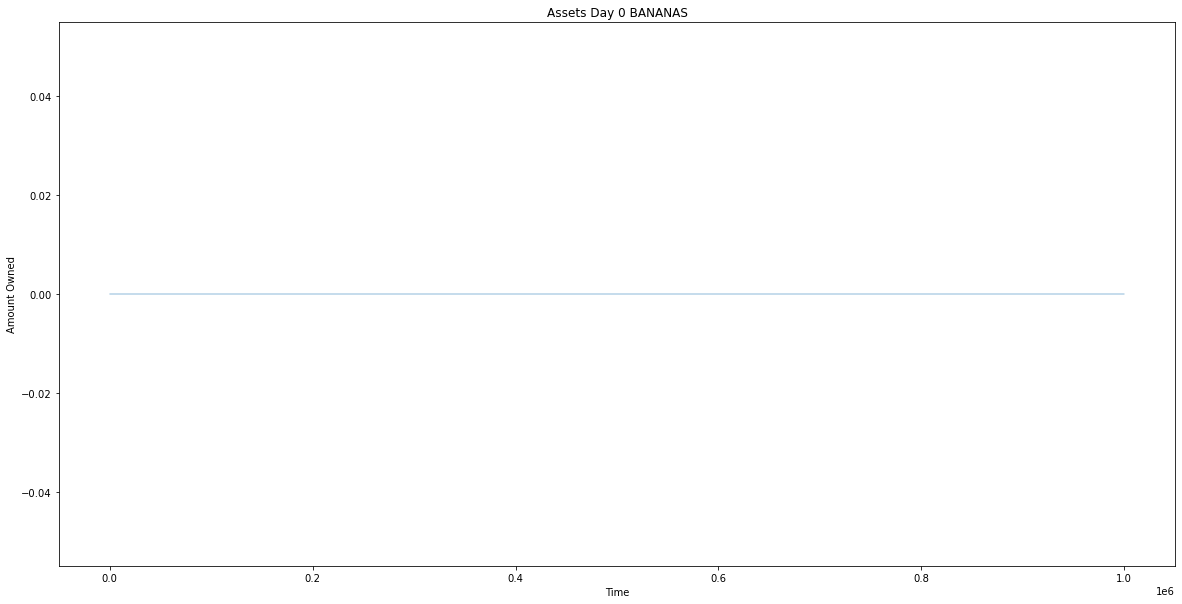

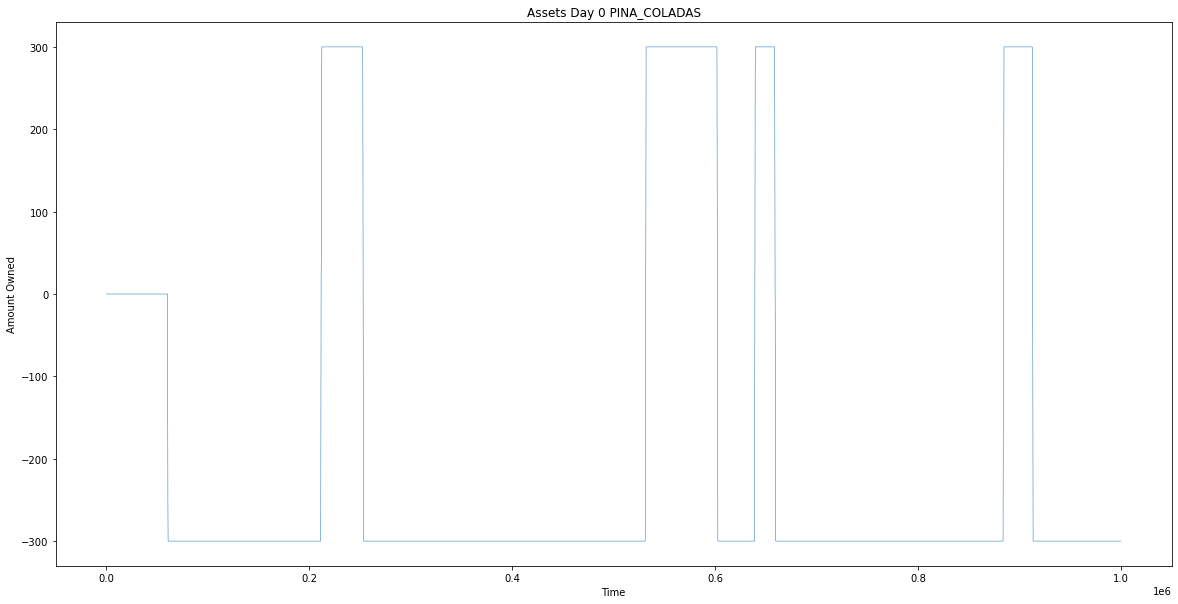

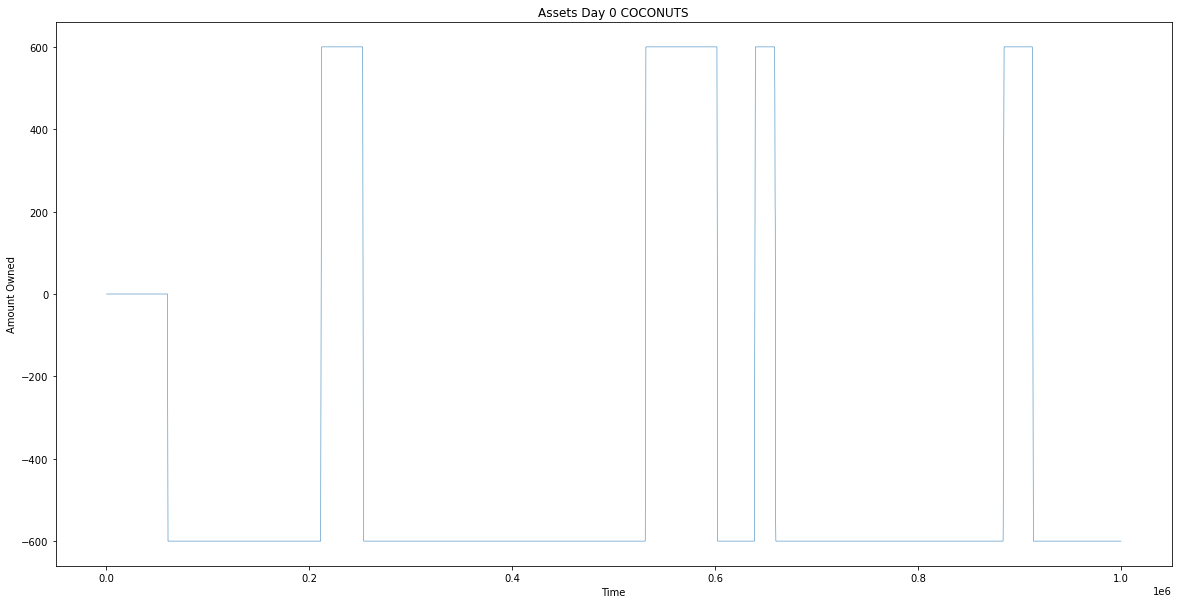

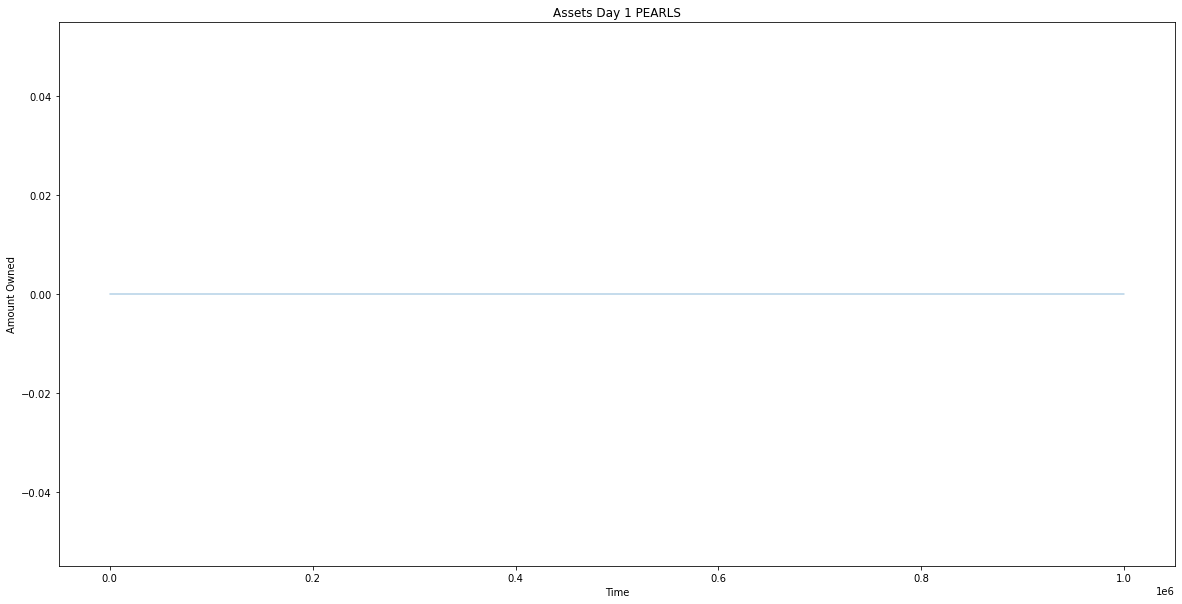

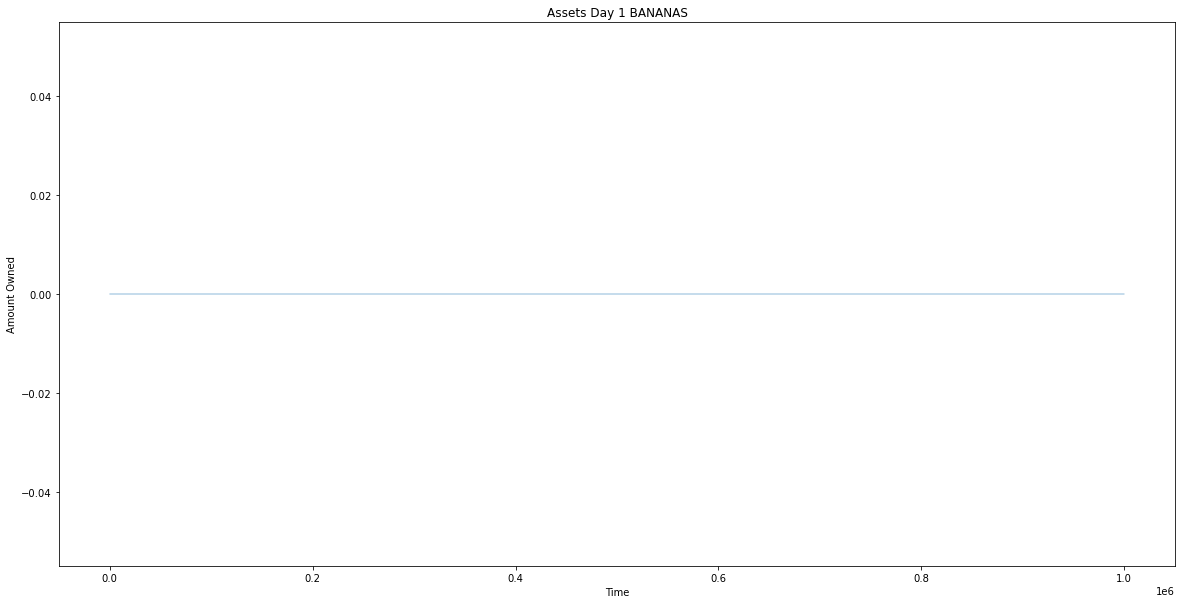

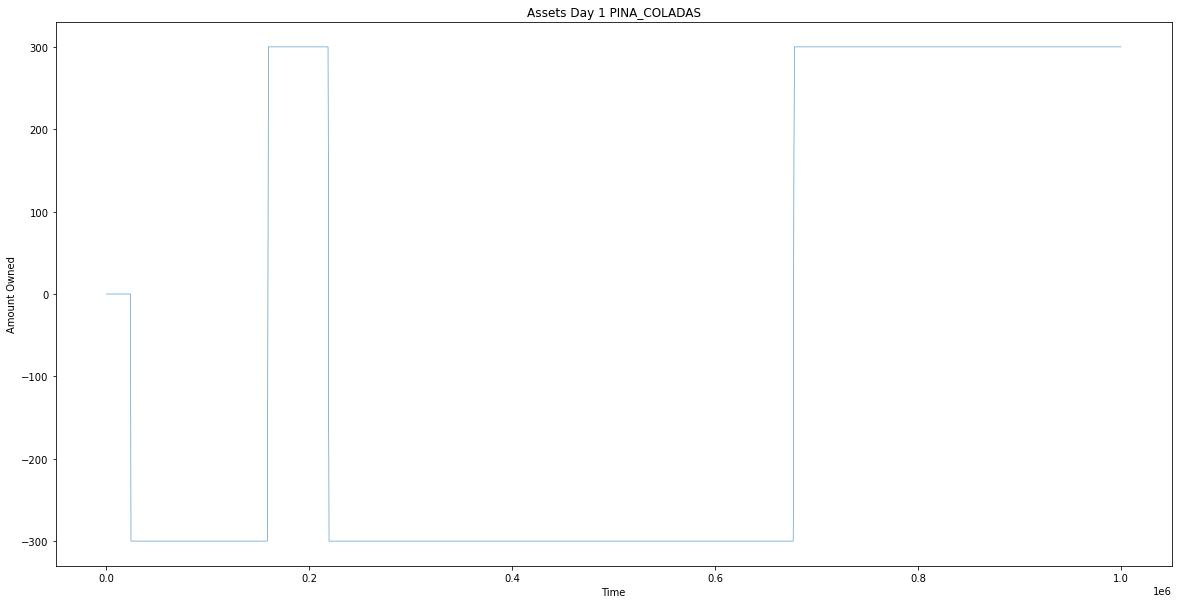

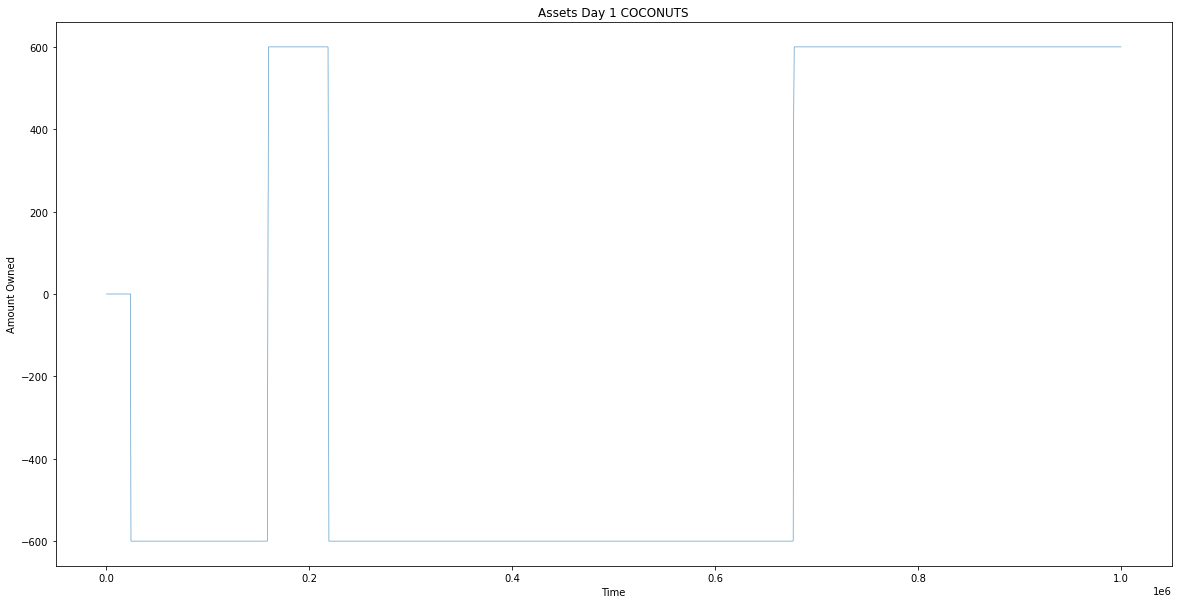

In [ ]:
for day, data in outputs.items():
    for product in data.products:
        plt.plot(data.mtm_value[product] , linewidth = 0.5)
        plt.xlabel('Time')
        plt.ylabel('Amount Owned')
        plt.title('Assets Day ' + str(day)+' '+product)
        plt.show()